### Sales Forecast

**Motivation! What's the context?**
- In 2017 Olist started to forecast its monthly sales based on the average revenue from 3 months before. But now the company  wants to be able to predict future sales more accurately.

**Why?**
- To efficiently allocate resources for future projects, growth and manage its cash flow. 

**Who are the stakeholders?**
- The financial sector will use the forecast to the set operating budgets and to project cash flows.
- And the marketing team, who will have the opportunity to schedule promotions if it appears sales <br>
will be weak and will be able to better allocate budget among other marketing activities.

**What is the deliverable?**
- A dashboard with the information about the forecast.


> **ps: We will use the data to forecast the second quarter of 2018 and the third quarter will be our "production data".**

## Agenda

[Cycles Notes](#Cycles-Notes)<br>

[0.0 Loading Data](#0.0-Loading-Data)<br>
&nbsp;[0.1 Train Test Time Period](#0.1-Train-Test-Time-Period)<br>

[1.0 Feature Engineering](#1.0-Feature-Engineering)<br>

[2.0 Modeling](#2.0-Modeling)<br>
&nbsp;[2.1 Training Test Split](#2.1-Training-Test-Split)<br>
&nbsp;[2.2 Random Forest](#2.2-Random-Forest)<br>
&nbsp;&nbsp;[2.2.1 Last month orders to next month revenue](#2.2.1-Last-month-orders-to-next-month-revenue)<br>

[3.0 ARIMA](#3.0-ARIMA)<br>
&nbsp;[](#)<br>
&nbsp;[](#)<br>
&nbsp;[](#)<br>






# Cycles Notes

**1st - Is the number of orders quite predictive?**

On average, our predictions are 4.09% above or below the real value.<br>
Which means an error of about R$ 42939.1

        Yes. This is not a feature we have at prediction time, though.
        
        Crazily, We could use the number of orders from last month to estimate
        the next one, but this doesn't help much when forecasting a larger period.

**2nd - Hummmm... Tempting.**

On average, our predictions are 5.16% above or below the real value.<br>
Which means an error of about R$ 53323.36

        It can be useful if we need a quick prediction for 1 month distance, which
        is not our objective here, so...
        
        If ARIMA doesn't help much, we can go back to ML models creating new flags
        as last_month_revenue_is_greater_than_this_one...

**3rd - ARIMA Is Good.**

On average, our predictions are 7.43% above or below the real value.<br>
Which means an error of about R$ 79515.33

        We beated the baseline and solved the features problem.


In [2]:
from notebook_utils.utils import *
from notebook_utils.ml_utils import *

import os 
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression # Similar Results
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA

In [3]:
directory = Directory("1.1-pr-sales-prediction-machine-learning")

## 0.0 Loading Data

In [4]:
data_frame_to_process = pd.read_pickle(os.path.join(os.path.join(directory.DATA_DIR, "sales_forecast_data"), "ml_data_to_preprocess.pkl"))
data_frame_to_process['revenue'] = data_frame_to_process['freight_value'] + data_frame_to_process['price']

data_frame = data_frame_to_process.copy()

### 0.1 Train Test Time Period

In [5]:
mask = (data_frame['order_purchase_timestamp'] < '2018-4-1')
x_train_index = data_frame.loc[mask].drop(columns=['revenue']).index

mask = (data_frame['order_purchase_timestamp'] >= '2018-4-1')
x_test_index = data_frame.loc[mask].drop(columns=['revenue']).index

## 1.0 Feature Engineering

In [18]:
# data_frame.columns

In [6]:
functions = {'revenue':'sum', 'order_id':'count'}
df = data_frame.groupby([data_frame['order_purchase_timestamp'].dt.year,
                         data_frame['order_purchase_timestamp'].dt.month]).\
                agg(functions)
df.columns = ['revenue','n_orders']
df

revenue  n_orders
order_purchase_timestamp order_purchase_timestamp                      
2017                     1                          127367.44       911
                         2                          269399.65      1845
                         3                          413517.85      2891
                         4                          390205.37      2563
                         5                          564882.30      3992
                         6                          487400.36      3472
                         7                          564067.13      4409
                         8                          643593.37      4782
                         9                          697148.71      4724
                         10                         749240.68      5201
                         11                        1149233.20      8452
                         12                         841078.16      6171
2018                     1                         1076273.40      8022
                         2                          963208.29      7495
                         3                         1117526.68      7994
                         4                         1130099.01      7805
                         5                         1126620.93      7789
                         6                         1009037.40      6990
                         7                         1024797.19      6941
                         8                          982649.62      7120

## 2.0 Modeling
### 2.1 Training Test Split

In [7]:
x_train = pd.concat([df.loc[2017, :], df.loc[2018, :].loc[:3]]).drop(columns='revenue')
y_train = pd.concat([df.loc[2017, 'revenue'], df.loc[2018, 'revenue'].loc[:3]])

x_test = df.loc[2018, :].loc[4:].drop(columns='revenue')
y_test = df.loc[2018, 'revenue'].loc[4:]

### 2.2 Random Forest

In [8]:
rf = RandomForestRegressor(min_samples_leaf=1)
rf.fit(x_train, y_train)

rf_predictions = rf.predict(x_test)
evaluation(y_test, rf_predictions)

On average, our predictions are 3.75% above or below the real value.
Which means an error of about R$ 39334.08


(39334.08, 3.7466278096767023)

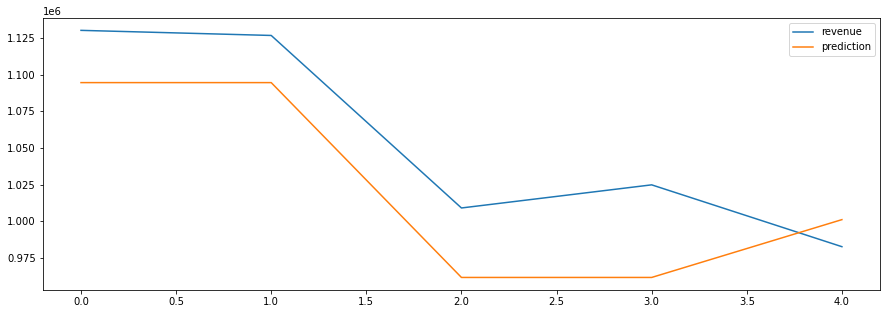

In [9]:
rf_evaluation = pd.concat([pd.Series(y_test.ravel(), name='revenue'), pd.Series(rf_predictions.ravel(), name='prediction')], axis=1)
rf_evaluation.plot(figsize=(15,5));

#### 2.2.1 Last month orders to next month revenue

In [10]:
new_x_test = x_test.copy()
new_x_test = new_x_test.append(x_train.iloc[-1]).sort_index()
new_x_test[:-1]

,n_orders
order_purchase_timestamp,
3,7994
4,7805
5,7789
6,6990
7,6941


In [11]:
rf_predictions = rf.predict(new_x_test[:-1])
evaluation(y_test, rf_predictions)

On average, our predictions are 4.32% above or below the real value.
Which means an error of about R$ 44852.86


(44852.86, 4.322558619629039)

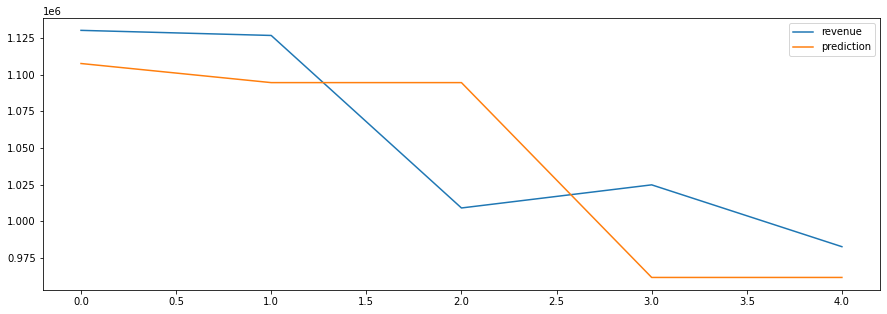

In [12]:
rf_evaluation = pd.concat([pd.Series(y_test.ravel(), name='revenue'), pd.Series(rf_predictions.ravel(), name='prediction')], axis=1)
rf_evaluation.plot(figsize=(15,5));

## 3.0 ARIMA

In [63]:
model = ARIMA(y_train.values, order=(5,1,0)).fit()
predictions = model.forecast(5)
evaluation(y_test, predictions)

On average, our predictions are 7.43% above or below the real value.
Which means an error of about R$ 79515.33


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(79515.33, 7.4265980846324675)

In [69]:
evaluation(y_test[:3], predictions[:3])

On average, our predictions are 6.56% above or below the real value.
Which means an error of about R$ 73701.51


(73701.51, 6.560150314625545)

In [68]:
evaluation(y_test[3:], predictions[3:])

On average, our predictions are 8.73% above or below the real value.
Which means an error of about R$ 88236.05


(88236.05, 8.726269739642849)

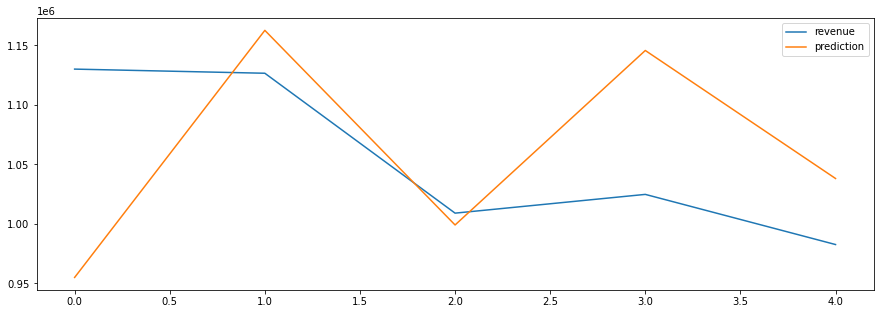

In [51]:
rf_evaluation = pd.concat([pd.Series(y_test.ravel(), name='revenue'), pd.Series(predictions.ravel(), name='prediction')], axis=1)
rf_evaluation.plot(figsize=(15,5));

In [32]:
train = data_frame.loc[x_train_index]
test = data_frame.loc[x_test_index]

df_regions_train = train.groupby([train['region'],train['order_purchase_timestamp'].dt.year,
                         train['order_purchase_timestamp'].dt.month])['revenue'].sum()
df_regions_test = test.groupby([test['region'],test['order_purchase_timestamp'].dt.year,
                         test['order_purchase_timestamp'].dt.month])['revenue'].sum()

In [34]:
model = ARIMA(df_regions_train.loc['midwest'].values, order=(5,1,0)).fit()
predictions = model.forecast(5)
evaluation(df_regions_test.loc['midwest'], predictions)

On average, our predictions are 10.73% above or below the real value.
Which means an error of about R$ 7243.7


(7243.7, 10.726085201122403)

In [38]:
df_regions_test.loc['midwest'],predictions

(order_purchase_timestamp  order_purchase_timestamp
 2018                      4                           62314.02
                           5                           80906.82
                           6                           62696.21
                           7                           71079.73
                           8                           54542.03
 Name: revenue, dtype: float64,
 array([58857.80505631, 67656.1908482 , 61053.24668803, 62463.52901861,
        63794.5068759 ]))

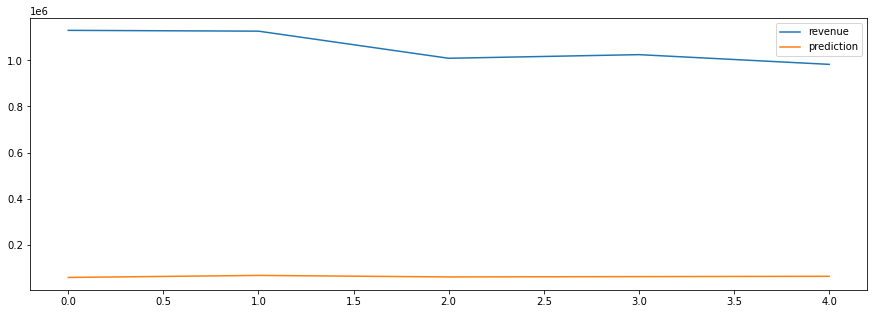

In [35]:
rf_evaluation = pd.concat([pd.Series(y_test.ravel(), name='revenue'), pd.Series(predictions.ravel(), name='prediction')], axis=1)
rf_evaluation.plot(figsize=(15,5));

In [ ]:
df_test['order_purchase_timestamp'].dt.week

In [87]:
a = pd.concat([pd.Series(df_test.values.ravel(), name='revenue'), pd.Series(predictions.ravel(), name='prediction')], axis=1)
a.index = df_test.index.get_level_values(1)
a = a.groupby("order_purchase_timestamp").sum()

evaluation(a.revenue, a.prediction)

On average, our predictions are 12.87% above or below the real value.
Which means an error of about R$ 134033.27


(134033.27, 12.872727137688639)